In [1]:
# load libraries
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
from scipy.optimize import brute, fmin
from scipy.integrate import quad
import yfinance as yf
from sklearn.linear_model import Lasso, LassoCV

# **STEP 2 - Computations**




**Category 1**

In [2]:
# Create Training Dataset and Testing Dataset

# Define the ticker symbols and corresponding names
tickers = {
    'DXY': 'DX-Y.NYB',
    'GOLD': 'GLD',  # Gold ETF
    'SILVER': 'SLV',  # Silver ETF
    'US_STK': '^GSPC',
    'X13W_TB': '^IRX',
    'X10Y_TBY': '^TNX',
    'EURUSD': 'EURUSD=X'
}

# Define the start and end dates
start_date = '2022-01-01'
end_date = '2023-12-31'

# Fetch the data from Yahoo Finance
data = {}
for key, ticker in tickers.items():
    data[key] = yf.download(ticker, start=start_date, end=end_date)['Adj Close']

# Create a DataFrame with the fetched data
df = pd.DataFrame(data)

# Calculate daily returns
daily_returns = df.pct_change().dropna()

# Split the data into training and testing sets
train_data = daily_returns.loc['2022-01-01':'2022-12-31']
test_data = daily_returns.loc['2023-01-01':'2023-12-31']

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [3]:
# Separate training data into dependent (y) and independent (x) variables
train_data_y = train_data[['DXY']]
train_data_x = train_data.drop(columns=['DXY'])

# Separate testing data into dependent (y) and independent (x) variables
test_data_y = test_data[['DXY']]
test_data_x = test_data.drop(columns=['DXY'])

In [4]:

# generate a sequence of lambdas to try
lambdas = [np.power(10, i) for i in np.arange(6, -6, -0.1)]

# Compile model
lasso_cv = LassoCV(cv=10, alphas=lambdas)
lasso_cv.fit(train_data_x,train_data_y)  # Fit Model

# Build final LASSO regression model
lasso_final = Lasso(alpha=lasso_cv.alpha_, fit_intercept=True)
lasso_final.fit(train_data_x,train_data_y)

print(
    "\n",
    pd.DataFrame(
        (lasso_final.coef_),
        index=['GOLD', 'SILVER', 'US_STK','X13W_TB', 'X10Y_TBY','EURUSD'],
        columns=["Coef."],
    ),
)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:1568: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



              Coef.
GOLD     -0.214884
SILVER   -0.015571
US_STK   -0.150072
X13W_TB   0.000691
X10Y_TBY  0.006786
EURUSD   -0.058955


In [5]:
# R squared formula and mean squared error
lasso_pred = lasso_final.predict(test_data_x)
#lasso_actual = test_data_y

# Ensure both predicted and actual values are in the same shape
lasso_actual = np.array(test_data_y).flatten()
lasso_pred = lasso_pred.flatten()

lasso_rss = np.sum(np.power(lasso_pred - lasso_actual, 2))
lasso_tss = np.sum(np.power(lasso_actual - np.mean(lasso_actual), 2))
lasso_rsq = 1 - lasso_rss / lasso_tss
print("\n LASSO_R^2: ", lasso_rsq)


 LASSO_R^2:  0.3963971289816126


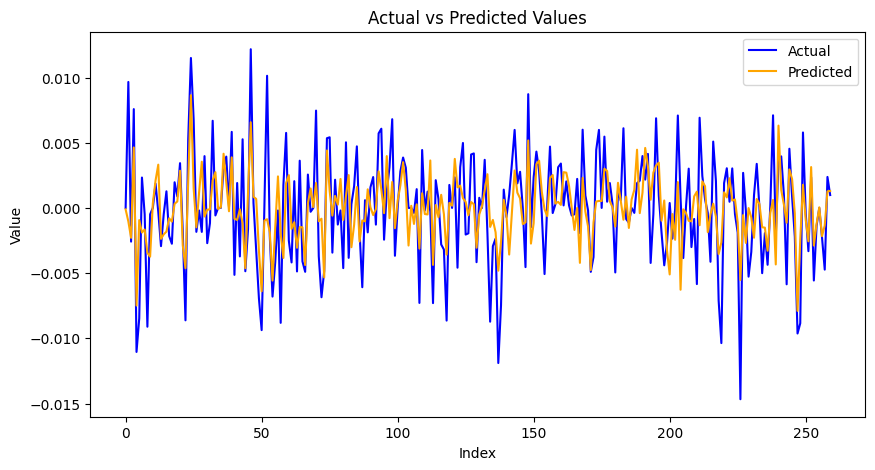

In [6]:
# Predicting values using the Lasso model on test data
lasso_pred = lasso_final.predict(test_data_x)

# Assuming test_data_y is a pandas Series, reset the index
test_data_y_reset = test_data_y.reset_index(drop=True)
lasso_pred_reset = pd.Series(lasso_pred).reset_index(drop=True)

# Plotting the actual vs predicted values
plt.figure(figsize=(10, 5))
plt.plot(test_data_y_reset, label='Actual', color='blue')
plt.plot(lasso_pred_reset, label='Predicted', color='orange')
plt.legend()
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values')
plt.show()

**Category 2: Hierarchical Clustering**

In [7]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist
from sklearn.cluster import AgglomerativeClustering


plt.style.use("seaborn-darkgrid")
sns.set_theme()
%matplotlib inline

<ipython-input-7-31bce5a85774>:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-darkgrid")


In [8]:
#downloading forex data
def download_forex_data(tickers, start_date, end_date):
    data = {}
    for ticker in tickers:
        forex_data = yf.download(ticker, start=start_date, end=end_date)
        forex_data = forex_data.reset_index()
        data[ticker] = forex_data[['Date', 'Adj Close']]
        data[ticker].rename(columns={'Adj Close': ticker}, inplace=True)
    return data

tickers = ["USDEUR=X", "USDRUB=X", "USDGBP=X", "USDJPY=X", "USDKES=X", "USDCNY=X",
           "USDKRW=X", "USDSGD=X", "USDTWD=X", "USDNGN=X", "USDZAR=X", "USDMYR=X",
           "USDIDR=X", "USDTHB=X", "USDAUD=X", "USDNZD=X", "USDCAD=X", "USDCHF=X",
           "USDNOK=X", "USDSEK=X", "USDARS=X", "USDPLN=X", "USDPHP=X", "USDRON=X",
           "USDHUF=X", "USDBRL=X", "USDCLP=X", "USDMXN=X", "USDCOP=X", "USDILS=X",
           "USDTRY=X", "USDINR=X"]

In [9]:
start_date = "2019-01-02"
end_date = "2022-06-30"
forex_data = download_forex_data(tickers, start_date, end_date)

[*********************100%%**********************]  1 of 1 completed
<ipython-input-8-c9bdd524baff>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[ticker].rename(columns={'Adj Close': ticker}, inplace=True)
[*********************100%%**********************]  1 of 1 completed
<ipython-input-8-c9bdd524baff>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[ticker].rename(columns={'Adj Close': ticker}, inplace=True)
[*********************100%%**********************]  1 of 1 completed
<ipython-input-8-c9bdd524baff>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See

In [10]:
df_currencies = pd.concat([data.set_index('Date') for data in forex_data.values()], axis=1)
df_currencies.fillna(method="ffill", inplace=True)
print(df_currencies.isna().sum().sum())

0


In [11]:
#Normalizng the data
sc = StandardScaler()
subset_scaled_df = pd.DataFrame(sc.fit_transform(df_currencies), columns=df_currencies.columns)

In [12]:
#percentage returns
df_returns = (df_currencies / df_currencies.shift(-1)) - 1
subset_scaled_df.drop(subset_scaled_df.tail(1).index, inplace=True)

#hierarchical clustering using different linkage methods
linkage_methods = ["single", "complete", "average", "ward"]

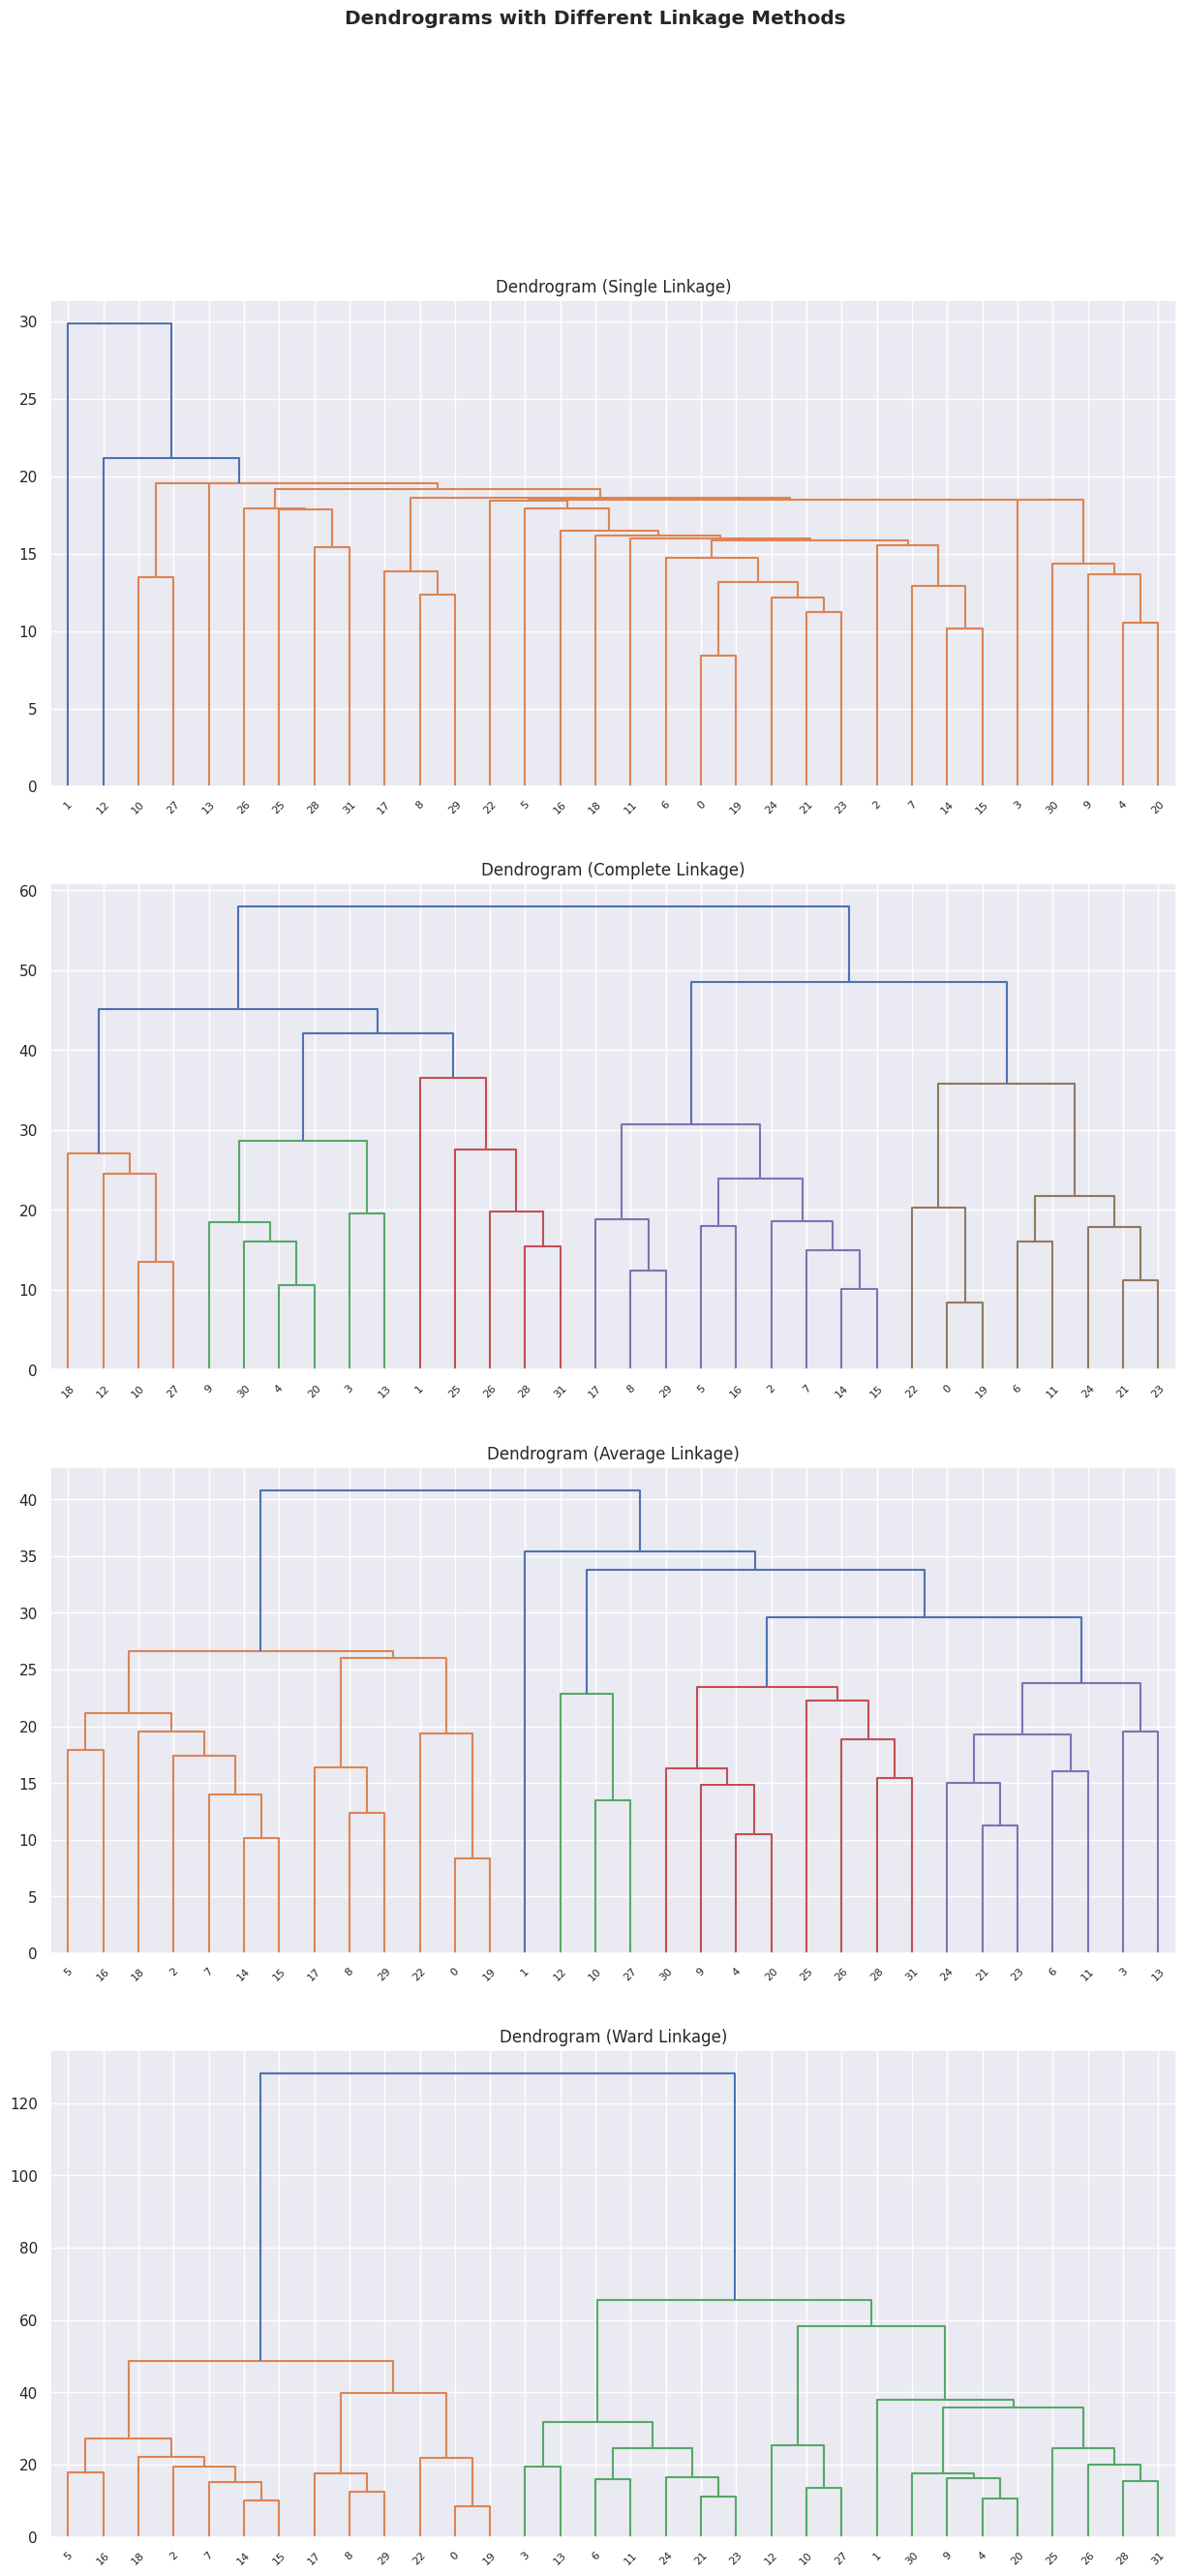

In [13]:
fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(15, 30))
for i, method in enumerate(linkage_methods):
    Z = linkage(subset_scaled_df.T, method=method, metric="euclidean")
    dendrogram(Z, ax=axs[i])
    axs[i].set_title(f"Dendrogram ({method.capitalize()} Linkage)")
fig.suptitle("Dendrograms with Different Linkage Methods", fontweight="bold")
plt.show()

In [14]:
#Ward's method for clustering
Z = linkage(subset_scaled_df.T, method="ward", metric="euclidean")

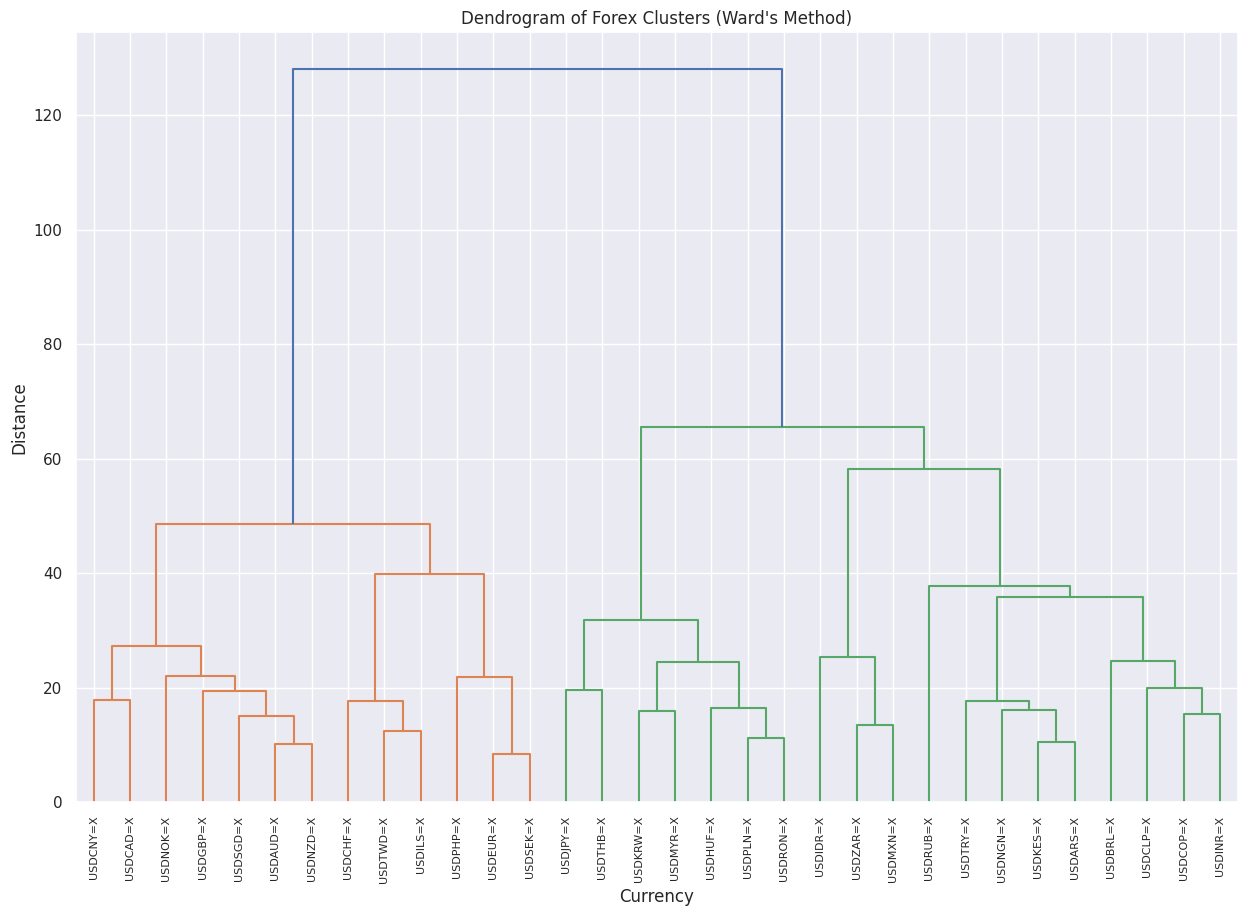

In [15]:
plt.figure(figsize=(15, 10))
plt.title("Dendrogram of Forex Clusters (Ward's Method)")
plt.xlabel("Currency")
plt.ylabel("Distance")
dendrogram(Z, labels=subset_scaled_df.columns, leaf_rotation=90)
plt.show()

In [16]:
num_clusters = 3
cluster_labels = fcluster(Z, num_clusters, criterion='maxclust')

#Adding cluster labels to the dataframe
df_currencies_t = df_currencies.T
df_currencies_t["Cluster"] = cluster_labels

In [17]:
#Displaying cluster's composition
for cluster in df_currencies_t["Cluster"].unique():
    print(f"Cluster {cluster}:")
    print(df_currencies_t[df_currencies_t["Cluster"] == cluster].index.values)
    print("-" * 100)

Cluster 1:
['USDEUR=X' 'USDGBP=X' 'USDCNY=X' 'USDSGD=X' 'USDTWD=X' 'USDAUD=X'
 'USDNZD=X' 'USDCAD=X' 'USDCHF=X' 'USDNOK=X' 'USDSEK=X' 'USDPHP=X'
 'USDILS=X']
----------------------------------------------------------------------------------------------------
Cluster 3:
['USDRUB=X' 'USDKES=X' 'USDNGN=X' 'USDZAR=X' 'USDIDR=X' 'USDARS=X'
 'USDBRL=X' 'USDCLP=X' 'USDMXN=X' 'USDCOP=X' 'USDTRY=X' 'USDINR=X']
----------------------------------------------------------------------------------------------------
Cluster 2:
['USDJPY=X' 'USDKRW=X' 'USDMYR=X' 'USDTHB=X' 'USDPLN=X' 'USDRON=X'
 'USDHUF=X']
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


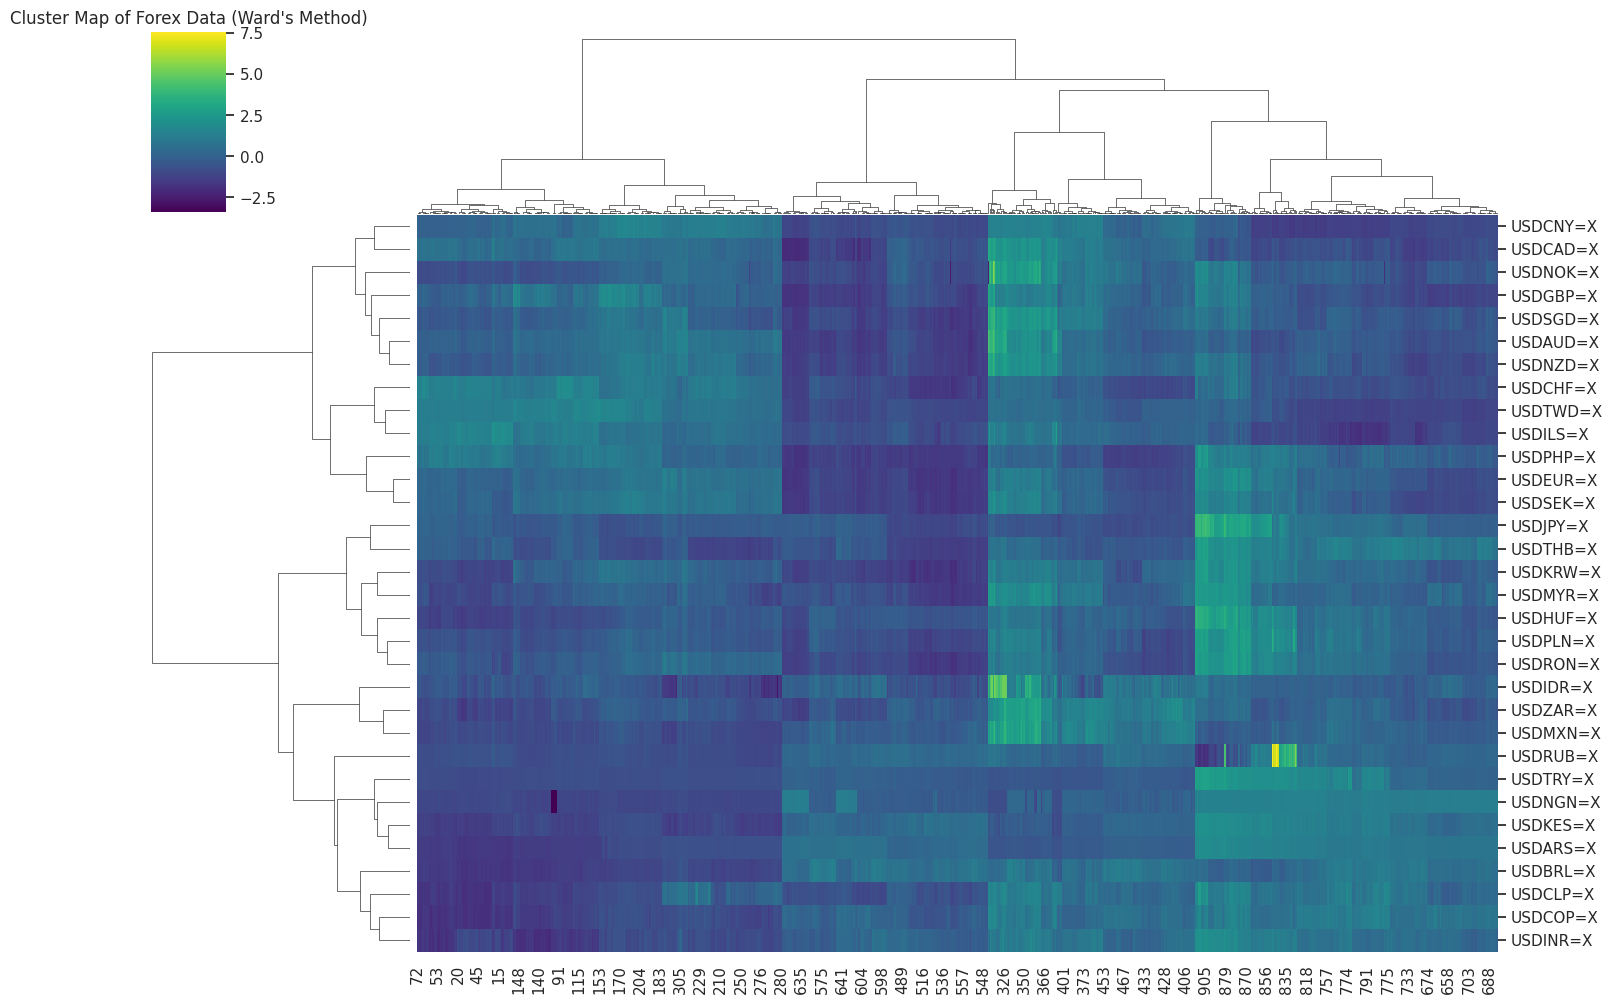

In [18]:
#Visualization of clusters
sns.clustermap(subset_scaled_df.T, method="ward", metric="euclidean", cmap="viridis", figsize=(15, 10))
plt.title("Cluster Map of Forex Data (Ward's Method)")
plt.show()

**Category 3: Principal components**

The method of PC analysis (PCA) is illustrated next. The application case is...

In [19]:
# Load libraries
# Global Libraries
# Disable the warnings
import warnings
from datetime import datetime

import numpy as np
import pandas as pd
import pandas_datareader.data as web
import scipy as sp

# Plotting
import seaborn as sns
from matplotlib import pyplot
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings("ignore")

from sklearn.decomposition import PCA

In [20]:
# downloading the data: stock prices from S&P500
start = datetime(2012, 6, 19)
end = datetime(2022, 6, 19)

stocks = ['MSFT', 'NVDA', 'AAPL', 'AMZN', 'META', 'GOOGL', 'JPM', 'TSLA', 'XOM']

#for s in stocks:
data = web.DataReader(stocks, 'stooq', start=start, end=end).Close
df = data.copy()

In [21]:
# calculate daily stock returns in terms of percentage changes
df = df.pct_change(1).dropna(axis=0)  #df.iloc[:-1]-df.iloc[1:]
#dd = dd.dropna(how="all").ffill()
print(df.head())

Symbols         MSFT      NVDA      AAPL      AMZN      META     GOOGL  \
Date                                                                     
2022-06-16 -0.010823 -0.017569 -0.011398 -0.024101 -0.017528 -0.010351   
2022-06-15  0.027719  0.059346  0.041283  0.038684  0.052713  0.035177   
2022-06-14 -0.028880 -0.041800 -0.019716 -0.049782 -0.033186 -0.027778   
2022-06-13 -0.009117 -0.011941 -0.006626  0.013293  0.003237 -0.003027   
2022-06-10  0.044290  0.084807  0.039809  0.057683  0.068854  0.044834   

Symbols          JPM      TSLA       XOM  
Date                                      
2022-06-16  0.003539 -0.016885  0.061194  
2022-06-15  0.017463  0.093383  0.038297  
2022-06-14 -0.011704 -0.051974  0.012752  
2022-06-13  0.016920 -0.023328 -0.002601  
2022-06-10  0.030697  0.076450  0.048096  


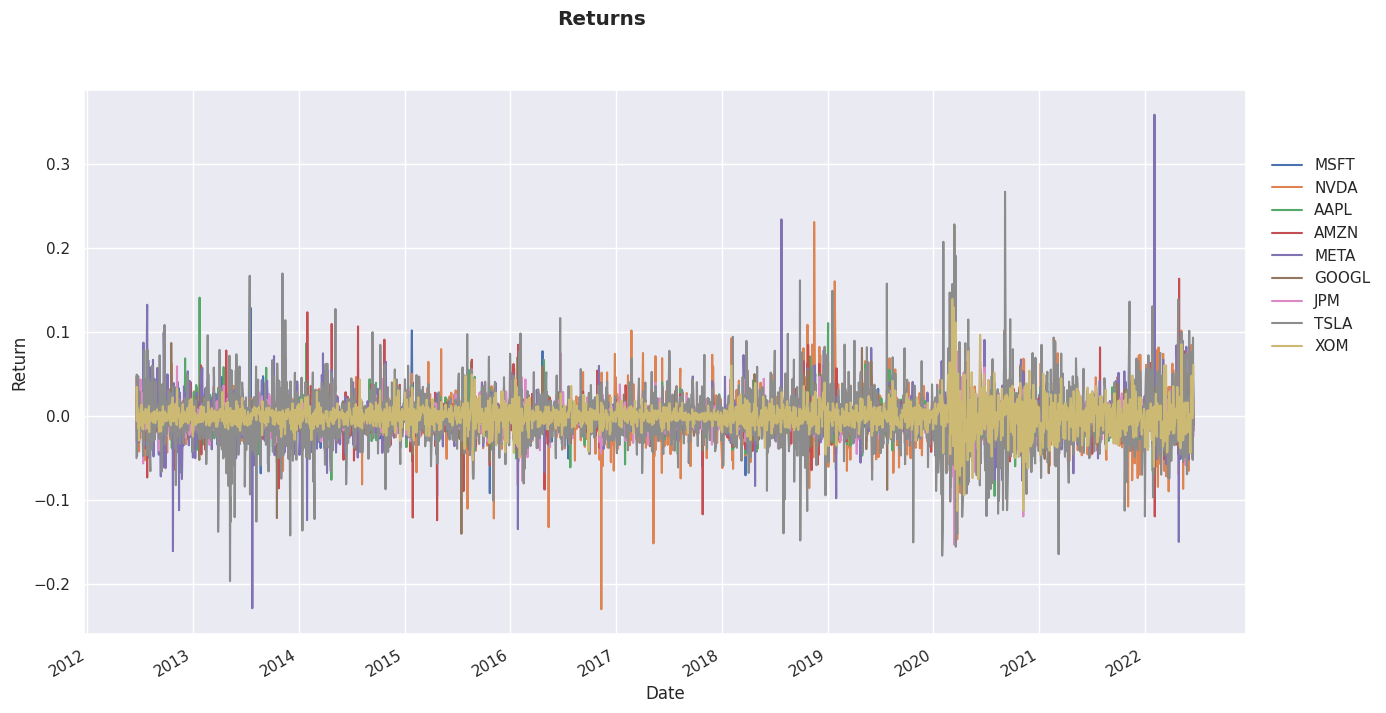

In [22]:
df.plot(figsize=(15, 8))
pyplot.ylabel("Return")
pyplot.legend(bbox_to_anchor=(1.01, 0.9), loc=2)
pyplot.suptitle(
    "Returns", fontweight="bold", horizontalalignment="right"
)
pyplot.show()

Let's now get principal components

In [23]:
# get principal components

# detrend data
df_std = (df - df.mean()) / df.std()
df_std.head()

Symbols,MSFT,NVDA,AAPL,AMZN,META,GOOGL,JPM,TSLA,XOM
Date,,,,,,,,,
2022-06-16,-0.606816,-0.609575,-0.593081,-1.184953,-0.708300,-0.595895,0.236403,-0.442482,3.751031
2022-06-15,1.720559,2.256885,2.307826,1.994163,2.189672,2.204035,1.065606,2.669874,2.348533
2022-06-14,-1.697216,-1.512615,-1.051088,-2.485299,-1.354306,-1.667646,-0.671364,-1.432884,0.783799
2022-06-13,-0.503819,-0.399840,-0.330299,0.708481,0.148404,-0.145483,1.033288,-0.624346,-0.156628
2022-06-10,2.721206,3.205771,2.226624,2.956169,2.855604,2.797919,1.853761,2.191912,2.948771


In [24]:
# get covariance matrix
cov_matrix_array = np.array(np.cov(df_std, rowvar=False))

cov_df = pd.DataFrame(cov_matrix_array, columns=df.columns, index=df.columns)

cov_df

Symbols,MSFT,NVDA,AAPL,AMZN,META,GOOGL,JPM,TSLA,XOM
Symbols,,,,,,,,,
MSFT,1.000000,0.592044,0.602031,0.571222,0.463380,0.675724,0.474186,0.379834,0.347618
NVDA,0.592044,1.000000,0.520977,0.495017,0.435469,0.544845,0.368798,0.383449,0.268288
AAPL,0.602031,0.520977,1.000000,0.481636,0.435784,0.551581,0.409802,0.363089,0.316177
AMZN,0.571222,0.495017,0.481636,1.000000,0.496748,0.613724,0.307693,0.363691,0.229286
META,0.463380,0.435469,0.435784,0.496748,1.000000,0.543076,0.303868,0.304945,0.215389
GOOGL,0.675724,0.544845,0.551581,0.613724,0.543076,1.000000,0.451644,0.365202,0.358981
JPM,0.474186,0.368798,0.409802,0.307693,0.303868,0.451644,1.000000,0.259492,0.593158
TSLA,0.379834,0.383449,0.363089,0.363691,0.304945,0.365202,0.259492,1.000000,0.201615
XOM,0.347618,0.268288,0.316177,0.229286,0.215389,0.358981,0.593158,0.201615,1.000000


In [25]:
# Perform eigendecomposition

eigenvalues, eigenvectors = np.linalg.eig(cov_matrix_array)

# Put data into a DataFrame and save to excel
df_eigval = pd.DataFrame({"Eigenvalues": eigenvalues})


# calculate explained variance
explained_variance = [round(variance / sum(eigenvalues), 3) for variance in eigenvalues]


# Save output to Excel
columns = [
    "PC1",
    "PC2",
    "PC3",
    "PC4",
    "PC5",
    "PC6",
    "PC7",
    "PC8",
    "PC9"
]
df_eigvec = pd.DataFrame(eigenvectors, columns=columns, index=df.columns)

df_eigvec

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
Symbols,,,,,,,,,
MSFT,0.391652,0.052807,-0.094991,-0.692580,0.297585,-0.346757,-0.354461,0.136282,0.046005
NVDA,0.350798,0.154299,0.045555,0.120785,0.411379,0.099108,0.220349,-0.245299,-0.740735
AAPL,0.356057,0.056458,-0.019538,0.135457,0.399939,0.144798,0.263886,-0.410769,0.657282
AMZN,0.348470,0.278306,-0.152172,-0.085451,-0.138533,0.482206,0.304226,0.649982,0.062543
META,0.316499,0.243737,-0.284001,-0.162669,-0.690913,-0.002072,0.000960,-0.502246,-0.060711
GOOGL,0.391091,0.082706,-0.197613,0.656431,-0.054665,-0.485878,-0.251370,0.257378,0.041950
JPM,0.303798,-0.567165,0.000177,0.102302,-0.042127,0.532667,-0.533307,-0.056289,-0.049709
TSLA,0.261049,0.163822,0.918970,0.006098,-0.222810,-0.051745,-0.065828,0.022006,0.057730
XOM,0.248553,-0.691375,0.033905,-0.110578,-0.176916,-0.306520,0.558281,0.088882,-0.044878


In [26]:
from itertools import accumulate

df_eigval["Explained proportion"] = df_eigval["Eigenvalues"] / np.sum(
    df_eigval["Eigenvalues"]
)
df_eigval["Cumulative Explained Variance"] = list(
    accumulate(df_eigval["Explained proportion"])
)

# Format as percentage
df_eigval.style.format({"Explained proportion": "{:.2%}"})
df_eigval.style.format({"Cumulative Explained Variance": "{:.2%}"})

,Eigenvalues,Explained proportion,Cumulative Explained Variance
0,4.476660,0.497407,49.74%
1,1.115402,0.123934,62.13%
2,0.746518,0.082946,70.43%
3,0.299975,0.033331,73.76%
4,0.603466,0.067052,80.47%
5,0.370184,0.041132,84.58%
6,0.407917,0.045324,89.11%
7,0.504772,0.056086,94.72%
8,0.475106,0.052790,100.00%


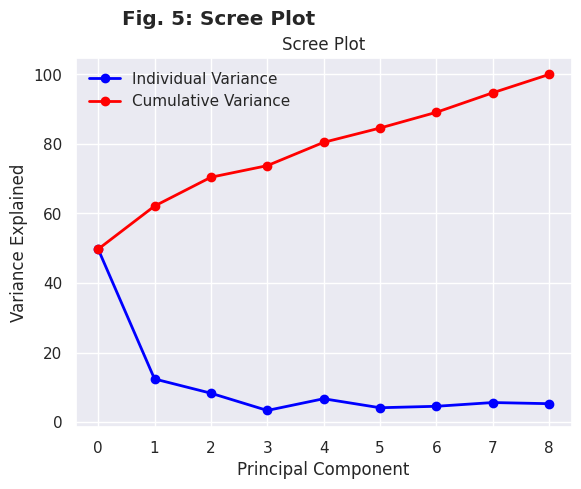

In [27]:
# plot scree plot
PC_values = np.arange(9)
pyplot.plot(
    PC_values, df_eigval["Explained proportion"] * 100, "o-", linewidth=2, color="blue"
)
pyplot.plot(
    PC_values,
    df_eigval["Cumulative Explained Variance"] * 100,
    "o-",
    linewidth=2,
    color="red",
)
pyplot.suptitle("Fig. 5: Scree Plot", fontweight="bold", horizontalalignment="right")
pyplot.title("Scree Plot")
pyplot.xlabel("Principal Component")
pyplot.ylabel("Variance Explained")
pyplot.legend(["Individual Variance", "Cumulative Variance"])
pyplot.show()

Note that in this case, the first PC explains 50 % of the variance, the second one around 10 %, and the resft of PCs explain similar variances (around 5 %). Therefore, to retrieve a large percentage of variances, we need a high number of PCs (6 PCs for close to 90 %). This indicates that most of the stocks chosen are uncorrelated, yet a low number of variables (the PCs) can represent a large amount of the index data. Future work could deepen into this analysis by considering a larger number of stocks from the SP500, and determine how many Pcs can retrieve a proper behaviour of the index.

# **STEP 3**

Lasso Regression

In [28]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

np.random.seed(42)

In [29]:
#Downloading Data
ticker = 'NVDA'
start_date = '2020-01-01'
end_date = '2024-01-01'

stock_data = yf.download(ticker, start=start_date, end=end_date)
stock_data['Returns'] = stock_data['Adj Close'].pct_change().dropna()

[*********************100%%**********************]  1 of 1 completed


In [30]:
# Define predictors (for simplicity, use lagged returns)
stock_data['Lagged_Returns'] = stock_data['Returns'].shift(1).dropna()

# Drop missing values
stock_data = stock_data.dropna()

# Define features and target variable
X = stock_data[['Lagged_Returns']]
y = stock_data['Returns']

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
#Defining model
lasso = Lasso()

#Defining hyperparameter grid
param_grid = {'alpha': np.logspace(-4, 0, 50)}

grid_search = GridSearchCV(lasso, param_grid, cv=5, scoring='neg_mean_squared_error')

grid_search.fit(X_train, y_train)

best_alpha = grid_search.best_params_['alpha']
print(f'Best alpha: {best_alpha}')

Best alpha: 0.0001


In [33]:
best_lasso = Lasso(alpha=best_alpha)
best_lasso.fit(X_train, y_train)

y_pred = best_lasso.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.0014837570650276092


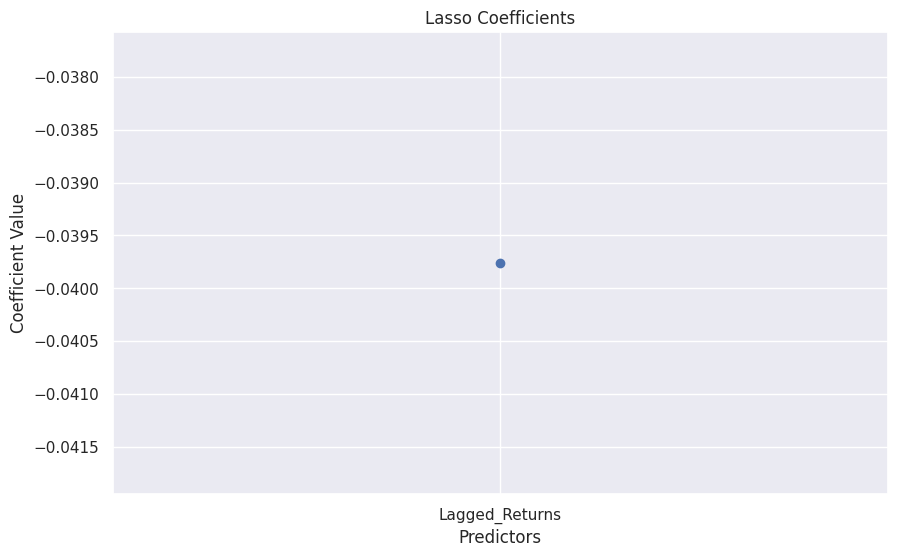

In [34]:
#Plotting Coefficients
plt.figure(figsize=(10, 6))
plt.plot(X_train.columns, best_lasso.coef_, marker='o')
plt.title('Lasso Coefficients')
plt.xlabel('Predictors')
plt.ylabel('Coefficient Value')
plt.show()

Hierarchical Clustering

In [35]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

sns.set(style="whitegrid")
plt.style.use("seaborn-darkgrid")
%matplotlib inline


In [36]:
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'JPM', 'GS', 'BAC', 'WFC', 'C']
start_date = '2022-01-01'
end_date = '2023-01-01'

# Download daily closing prices
data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']

returns = data.pct_change().dropna()

returns.head()


[*********************100%%**********************]  9 of 9 completed


Ticker,AAPL,AMZN,BAC,C,GOOGL,GS,JPM,MSFT,WFC
Date,,,,,,,,,
2022-01-04,-0.012692,-0.016916,0.039195,0.007765,-0.004083,0.030734,0.037910,-0.017147,0.039819
2022-01-05,-0.026600,-0.018893,-0.016879,-0.011637,-0.045876,-0.021719,-0.018282,-0.038388,-0.008720
2022-01-06,-0.016693,-0.006711,0.020136,0.032776,-0.000200,-0.004265,0.010624,-0.007902,0.025626
2022-01-07,0.000988,-0.004288,0.021816,0.013403,-0.005303,0.001461,0.009908,0.000510,0.021257
2022-01-10,0.000116,-0.006570,-0.005083,0.003800,0.012061,0.004176,0.000957,0.000732,0.010590


In [37]:
scaler = StandardScaler()
scaled_returns = scaler.fit_transform(returns)

scaled_returns_df = pd.DataFrame(scaled_returns, index=returns.index, columns=returns.columns)

#Euclidean distance
distance_matrix = pdist(scaled_returns_df.T, metric='euclidean')


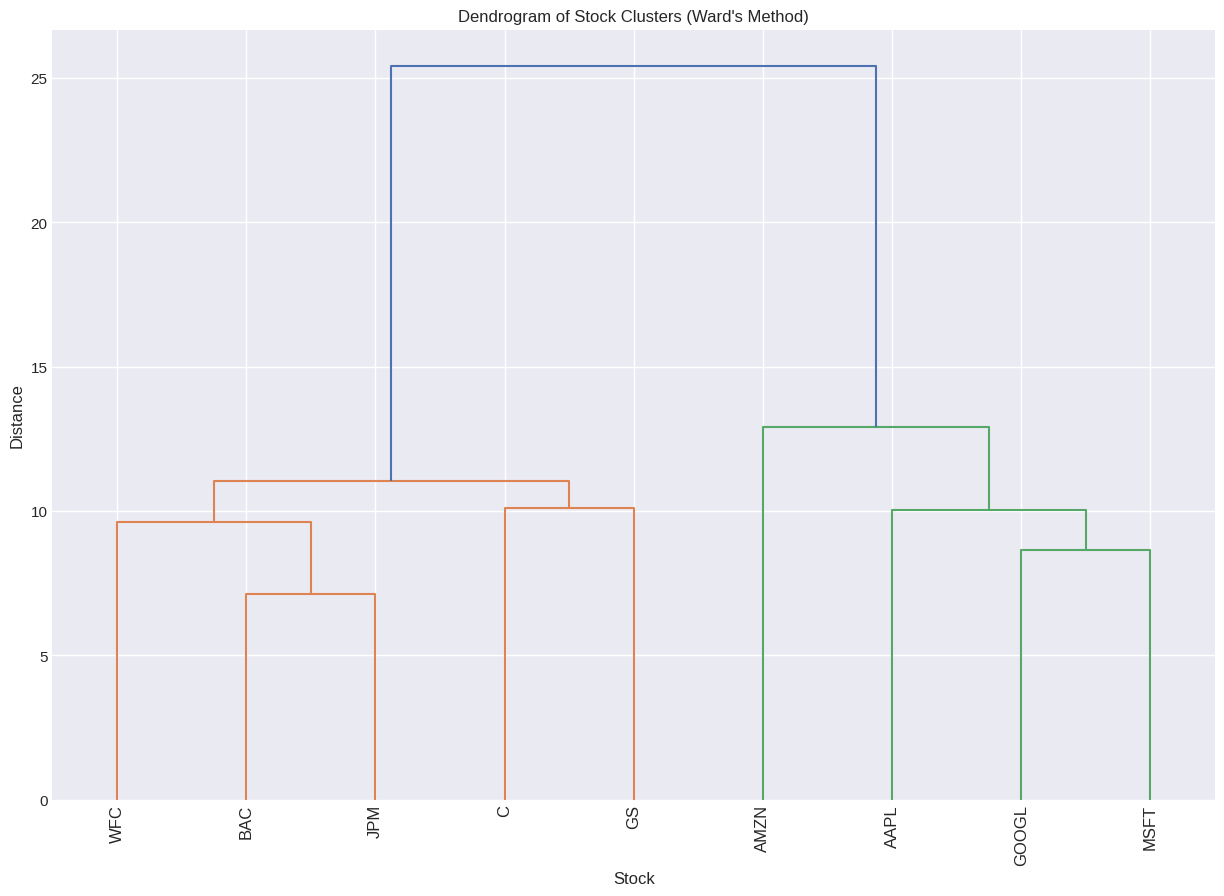

In [38]:
Z = linkage(distance_matrix, method='ward')

#dendrogram
plt.figure(figsize=(15, 10))
dendrogram(Z, labels=scaled_returns_df.columns, leaf_rotation=90, leaf_font_size=12)
plt.title('Dendrogram of Stock Clusters (Ward\'s Method)')
plt.xlabel('Stock')
plt.ylabel('Distance')
plt.show()


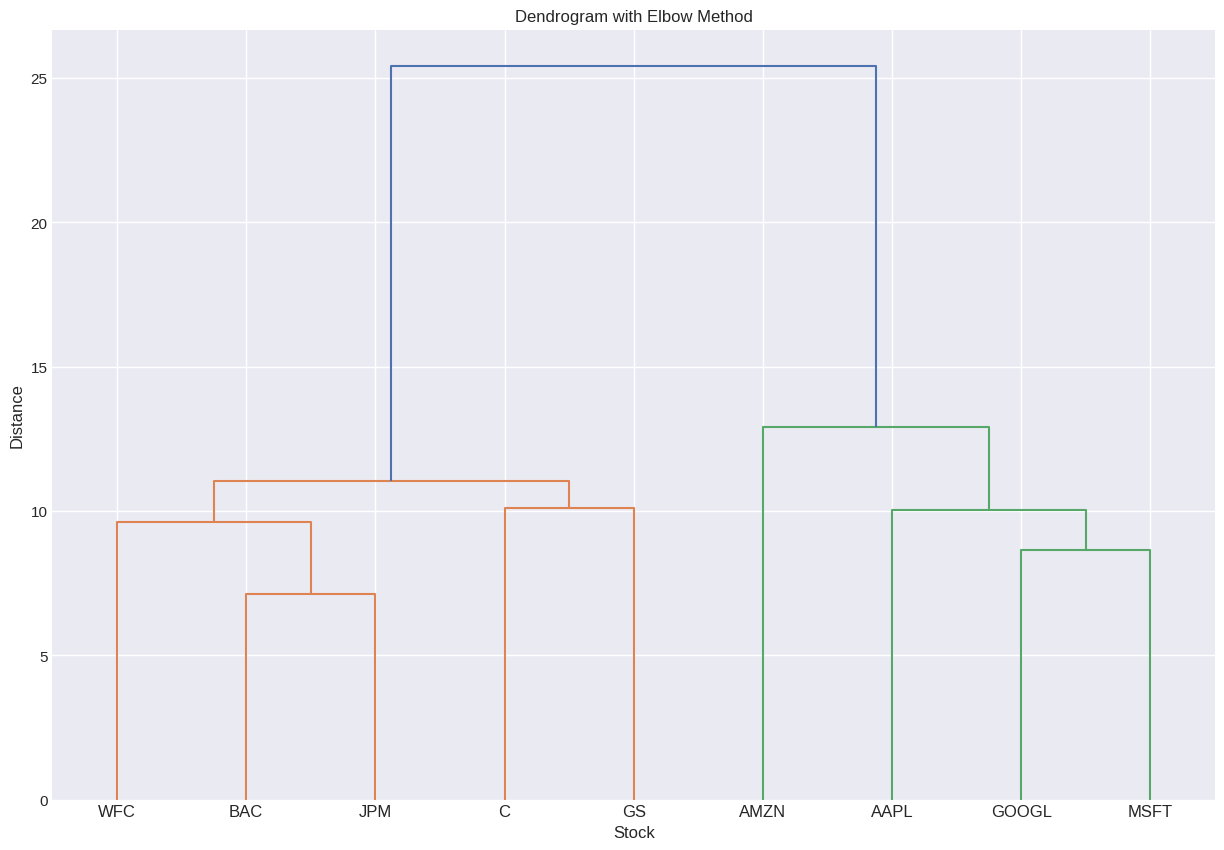

In [39]:
#determining the optimal number of clusters
def plot_dendrogram(model, **kwargs):
    #crearing linkage matrix and then plot the dendrogram
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    dendrogram(linkage_matrix, **kwargs)

from sklearn.cluster import AgglomerativeClustering

model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='ward')

model = model.fit(scaled_returns_df.T)

plt.figure(figsize=(15, 10))
plot_dendrogram(model, labels=scaled_returns_df.columns)
plt.title('Dendrogram with Elbow Method')
plt.xlabel('Stock')
plt.ylabel('Distance')
plt.show()


In [40]:
num_clusters = 3
cluster_labels = fcluster(Z, num_clusters, criterion='maxclust')

clustered_stocks = pd.DataFrame({'Stock': scaled_returns_df.columns, 'Cluster': cluster_labels})

#Evaluation of the clusters using silhouette score
silhouette_avg = silhouette_score(squareform(distance_matrix), cluster_labels, metric='precomputed')
print(f'Silhouette Score: {silhouette_avg}')

#Display the clustered stocks
print(clustered_stocks.sort_values(by='Cluster'))


Silhouette Score: 0.26977594015313294
   Stock  Cluster
2    BAC        1
3      C        1
5     GS        1
6    JPM        1
8    WFC        1
0   AAPL        2
4  GOOGL        2
7   MSFT        2
1   AMZN        3


Principal Components

In [41]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)

In [42]:
#Dounloading Data
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'JPM', 'GS', 'BAC', 'WFC', 'C']
start_date = '2020-01-01'
end_date = '2024-01-01'

data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']

returns = data.pct_change().dropna()

returns.head()

[*********************100%%**********************]  9 of 9 completed


Ticker,AAPL,AMZN,BAC,C,GOOGL,GS,JPM,MSFT,WFC
Date,,,,,,,,,
2020-01-03,-0.009722,-0.012139,-0.020763,-0.018836,-0.005231,-0.011693,-0.013197,-0.012452,-0.006139
2020-01-06,0.007969,0.014886,-0.001433,-0.003137,0.026654,0.010234,-0.000795,0.002585,-0.005990
2020-01-07,-0.004703,0.002092,-0.006600,-0.008685,-0.001932,0.006583,-0.017001,-0.009118,-0.008286
2020-01-08,0.016086,-0.007809,0.010110,0.007618,0.007118,0.009639,0.007801,0.015928,0.003038
2020-01-09,0.021241,0.004799,0.001715,0.009073,0.010498,0.020357,0.003652,0.012493,-0.001704


In [43]:
scaler = StandardScaler()
scaled_returns = scaler.fit_transform(returns)

pca = PCA()
pca.fit(scaled_returns)
explained_variance = np.cumsum(pca.explained_variance_ratio_)

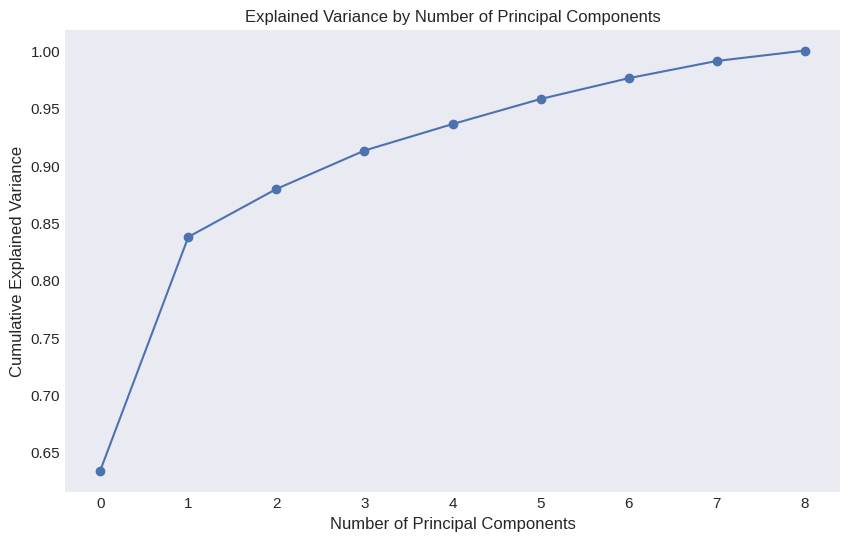

Number of components to retain: 6


In [44]:
plt.figure(figsize=(10, 6))
plt.plot(explained_variance, marker='o')
plt.title('Explained Variance by Number of Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.show()

#number of components
num_components = np.argmax(explained_variance >= 0.95) + 1
print(f'Number of components to retain: {num_components}')


In [45]:
pca = PCA(n_components=num_components)
principal_components = pca.fit_transform(scaled_returns)

# Creating DataFrame with the principal components
pc_df = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(num_components)])
pc_df.head()


,PC1,PC2,PC3,PC4,PC5,PC6
0,-1.696103,0.051460,0.058269,-0.222788,0.125109,-0.241872
1,0.608828,-0.952897,-0.216857,-0.541343,-0.517812,-0.535154
2,-0.809089,-0.099268,-0.317787,0.051350,-0.444100,-0.273544
3,1.000352,-0.113498,0.823868,0.036464,-0.112960,0.196693
4,1.136324,-0.540541,0.504995,0.273131,-0.627523,-0.127234


In [46]:
#SVD
svd_solvers = ['auto', 'full', 'arpack', 'randomized']
explained_variances = {}

for solver in svd_solvers:
    pca = PCA(n_components=num_components, svd_solver=solver)
    pca.fit(scaled_returns)
    explained_variances[solver] = np.sum(pca.explained_variance_ratio_)

    print(f'SVD Solver: {solver}')
    print(f'Explained Variance: {explained_variances[solver]}')
    print('-' * 50)

SVD Solver: auto
Explained Variance: 0.9577946337087656
--------------------------------------------------
SVD Solver: full
Explained Variance: 0.9577946337087667
--------------------------------------------------
SVD Solver: arpack
Explained Variance: 0.9577946337087675
--------------------------------------------------
SVD Solver: randomized
Explained Variance: 0.9577946337087653
--------------------------------------------------


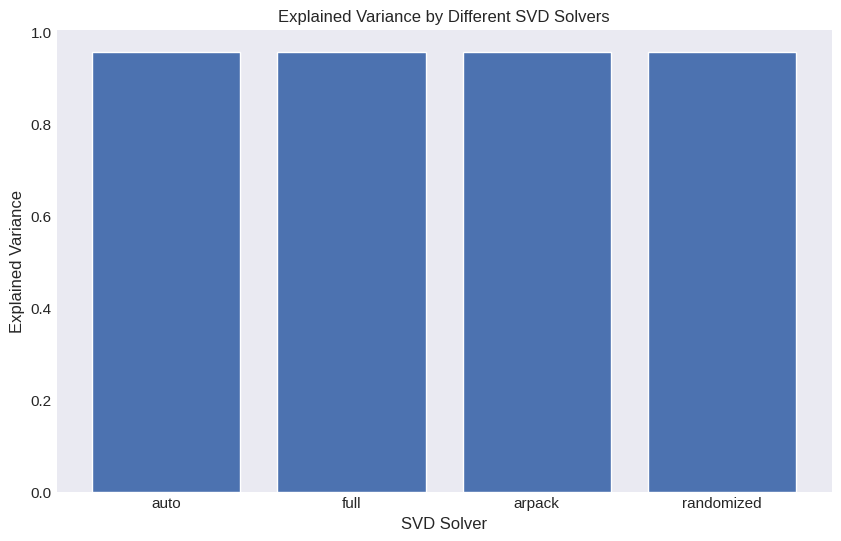

In [47]:
plt.figure(figsize=(10, 6))
plt.bar(explained_variances.keys(), explained_variances.values())
plt.title('Explained Variance by Different SVD Solvers')
plt.xlabel('SVD Solver')
plt.ylabel('Explained Variance')
plt.grid()
plt.show()